# 02_data_analysis (local VS Code)
Analyze % dF/F0 across groups from CSVs in data/raw; save plots and tables to data/processed.

## How to use


1. Place group CSVs under data/raw, one folder per genotype (e.g., data/raw/WT, data/raw/dr170). All CSVs in a folder are combined for that group.

2. Each CSV needs a time column named `Time (s) Adjusted` plus one column per trace.

3. Optionally map folder names to display names in `group_name_overrides`.

4. Run cells top-to-bottom; outputs go to data/processed.

In [1]:
# Config and imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import yaml

CONFIG_PATH = Path("config.yaml")
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

RAW_DIR = Path(config["paths"]["raw_dir"])
PROCESSED_DIR = Path(config["paths"]["processed_dir"])
COMBINED_DATA_DIR = Path(config["paths"]["combined_data_dir"])
FIGURES_DIR = Path(config["paths"]["figures_dir"])
FIGURE_DATA_DIR = Path(config["paths"]["figure_data_dir"])
FIGURE_STATS_DIR = Path(config["paths"]["figure_statistics_dir"])

# Create all output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
COMBINED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_STATS_DIR.mkdir(parents=True, exist_ok=True)

analysis_cfg = config["analysis"]
time_col = analysis_cfg["time_col"]
frame_rate_hz = analysis_cfg.get("frame_rate_hz")
stim_windows = analysis_cfg.get("stim_windows_s") or [analysis_cfg.get("stim_window_s", [20, 40])]
stim_window = tuple(stim_windows[0])
group_name_overrides = analysis_cfg.get("group_name_overrides", {})
genotypes = analysis_cfg.get("genotypes", [])
stimulus_info = config.get("stimulus", {})

# Auto-assign colors: use palette if specified, otherwise use default color cycle
palette = analysis_cfg.get("palette", {})
default_colors = ["black", "red", "blue", "green", "purple", "orange", "brown", "pink", "gray", "olive"]

# Check for mismatches between genotypes and palette
palette_genotypes = set(palette.keys())
config_genotypes = set(genotypes)
unused_palette = palette_genotypes - config_genotypes
missing_palette = config_genotypes - palette_genotypes

if unused_palette:
    print(f"⚠️  Warning: Palette has colors for genotypes not in genotypes list: {unused_palette}")
if missing_palette:
    print(f"ℹ️  Auto-assigning colors for genotypes not in palette: {missing_palette}")

# Assign colors
for i, genotype in enumerate(genotypes):
    if genotype not in palette:
        palette[genotype] = default_colors[i % len(default_colors)]

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.family"] = "DejaVu Sans"

In [2]:
# Display experiment metadata
project_info = config["project"]
stimulus_info = config.get("stimulus", {})

print("="*60)
print(f"Experiment: {project_info.get('name', 'N/A')}")
print(f"Date: {project_info.get('created', 'N/A')}")
print(f"GCaMP Transgene: {project_info.get('gcamp_transgene', 'N/A')}")
print(f"Description: {project_info.get('description', 'N/A')}")
print(f"Genotypes: {', '.join(analysis_cfg.get('genotypes', []))}")
print(f"Stimulus: {stimulus_info.get('type', 'N/A')} at {stimulus_info.get('concentration', 'N/A')} in {stimulus_info.get('buffer', 'N/A')}")
print(f"Frame Rate: {frame_rate_hz} Hz")
print(f"Stimulus Windows: {stim_windows}")
print("="*60)

Experiment: Witrado_et_al_2025
Date: 260123
GCaMP Transgene: etYIs1
Description: GCaMP6s in the ASH neuron only
Genotypes: wt, dr206, dr206 dr180
Stimulus: NaCl at 2M in S-basal
Frame Rate: 10 Hz
Stimulus Windows: [[20, 40]]


In [3]:
# Load per-genotype combined CSVs
def sanitize_name(name: str) -> str:
    return name.lower().replace(" ", "_").replace("-", "_")

group_data = {}

if not genotypes:
    raise ValueError("No genotypes listed in config.yaml under analysis.genotypes")

for genotype in genotypes:
    genotype_tag = sanitize_name(genotype)
    combined_path = COMBINED_DATA_DIR / f"combined_output_{genotype_tag}.csv"
    
    if not combined_path.exists():
        raise FileNotFoundError(f"Combined file not found: {combined_path}. Run 01_data_wrangling.ipynb first.")
    
    df = pd.read_csv(combined_path)
    
    if time_col not in df.columns:
        raise ValueError(f"{combined_path.name} is missing the time column '{time_col}'.")
    
    data_columns = [c for c in df.columns if c not in {time_col, config["wrangling"]["index_col_name"]}]
    if not data_columns:
        raise ValueError(f"{combined_path.name} has no data columns besides '{time_col}'.")
    
    group_df = df[[time_col] + data_columns].copy()
    group_data[genotype] = group_df
    print(f"Loaded '{genotype}' from {combined_path.name} with {len(data_columns)} traces")

print(f"\nAll groups loaded: {list(group_data.keys())}")

Loaded 'wt' from combined_output_wt.csv with 30 traces
Loaded 'dr206' from combined_output_dr206.csv with 30 traces
Loaded 'dr206 dr180' from combined_output_dr206_dr180.csv with 32 traces

All groups loaded: ['wt', 'dr206', 'dr206 dr180']


In [4]:
# Step 1: Background subtraction - subtract Mean2 from Mean1 for each trace
import re

group_data_bg_subtracted = {}

for genotype, df in group_data.items():
    data_cols = [c for c in df.columns if c != time_col]
    
    # Group columns by their base filename (everything before _Mean1 or _Mean2)
    trace_names = set()
    for col in data_cols:
        match = re.match(r"(.+)_(Mean[12])$", col)
        if match:
            trace_names.add(match.group(1))
    
    # For each trace, find Mean1 and Mean2 and subtract
    bg_subtracted_traces = []
    for trace_name in sorted(trace_names):
        mean1_col = f"{trace_name}_Mean1"
        mean2_col = f"{trace_name}_Mean2"
        
        if mean1_col in df.columns and mean2_col in df.columns:
            f_bg_subtracted = df[mean1_col] - df[mean2_col]
            f_bg_subtracted.name = trace_name  # Use the base name without column suffix
            bg_subtracted_traces.append(f_bg_subtracted)
        else:
            print(f"⚠️  Warning: Missing Mean1 or Mean2 for {trace_name} in {genotype}")
    
    if not bg_subtracted_traces:
        raise ValueError(f"No valid trace pairs found for genotype '{genotype}'")
    
    # Create new DataFrame with time and background-subtracted traces
    bg_subtracted_df = pd.concat([df[time_col]] + bg_subtracted_traces, axis=1)
    group_data_bg_subtracted[genotype] = bg_subtracted_df
    print(f"{genotype}: {len(bg_subtracted_traces)} traces after background subtraction")

print("\nBackground subtraction complete for all genotypes")

wt: 15 traces after background subtraction
dr206: 15 traces after background subtraction
dr206 dr180: 16 traces after background subtraction

Background subtraction complete for all genotypes


In [5]:
# Step 2: Calculate F0 (baseline) as mean of 5 seconds before stimulus, then calculate F/F0
baseline_duration = 5  # seconds
baseline_end = stim_window[0]  # stimulus starts here
baseline_start = baseline_end - baseline_duration

group_data_normalized = {}

for genotype, df in group_data_bg_subtracted.items():
    # Get baseline window
    baseline_mask = (df[time_col] >= baseline_start) & (df[time_col] < baseline_end)
    baseline_df = df[baseline_mask]
    
    if len(baseline_df) == 0:
        raise ValueError(f"No data found in baseline window [{baseline_start}, {baseline_end}) for genotype '{genotype}'")
    
    # Calculate F0 for each trace (mean during baseline)
    data_cols = [c for c in df.columns if c != time_col]
    f0_values = baseline_df[data_cols].mean()
    
    # Calculate F/F0 for each trace
    normalized_traces = []
    for col in data_cols:
        f0 = f0_values[col]
        if f0 == 0:
            print(f"⚠️  Warning: F0 = 0 for {col} in {genotype}, skipping trace")
            continue
        f_over_f0 = df[col] / f0
        f_over_f0.name = col
        normalized_traces.append(f_over_f0)
    
    if not normalized_traces:
        raise ValueError(f"No valid normalized traces for genotype '{genotype}'")
    
    # Create new DataFrame with time and F/F0 traces
    normalized_df = pd.concat([df[time_col]] + normalized_traces, axis=1)
    group_data_normalized[genotype] = normalized_df
    print(f"{genotype}: {len(normalized_traces)} traces normalized (F/F0)")

print(f"\nNormalization complete. Baseline window: [{baseline_start}, {baseline_end}) seconds")

wt: 15 traces normalized (F/F0)
dr206: 15 traces normalized (F/F0)
dr206 dr180: 16 traces normalized (F/F0)

Normalization complete. Baseline window: [15, 20) seconds


In [6]:
# Step 3: Calculate % ΔF/F0 = (F/F0 - 1) * 100
group_data_delta_f_f0 = {}

for genotype, df in group_data_normalized.items():
    data_cols = [c for c in df.columns if c != time_col]
    
    # Calculate % ΔF/F0 for each trace
    delta_f_f0_traces = []
    for col in data_cols:
        delta_f_f0 = (df[col] - 1) * 100
        delta_f_f0.name = col
        delta_f_f0_traces.append(delta_f_f0)
    
    # Create new DataFrame with time and % ΔF/F0 traces
    delta_f_f0_df = pd.concat([df[time_col]] + delta_f_f0_traces, axis=1)
    group_data_delta_f_f0[genotype] = delta_f_f0_df
    print(f"{genotype}: {len(delta_f_f0_traces)} traces as % ΔF/F0")

print("\n% ΔF/F0 calculation complete for all genotypes")

wt: 15 traces as % ΔF/F0
dr206: 15 traces as % ΔF/F0
dr206 dr180: 16 traces as % ΔF/F0

% ΔF/F0 calculation complete for all genotypes


In [7]:
# Step 4: Bleaching correction - fit exponential to 10-15s and last 5s, then subtract
from scipy.optimize import curve_fit
import numpy as np

def exponential_func(t, a, b, c):
    """Single exponential: f(t) = a * exp(-b * t) + c"""
    return a * np.exp(-b * t) + c

bleach_fit_window1 = [10, 15]  # first window for fitting
bleach_fit_duration = 5  # last N seconds for fitting

group_data_bleach_corrected = {}

for genotype, df in group_data_delta_f_f0.items():
    data_cols = [c for c in df.columns if c != time_col]
    time_values = df[time_col].values
    max_time = time_values[-1]
    bleach_fit_window2 = [max_time - bleach_fit_duration, max_time]
    
    # Get data points for fitting
    mask1 = (df[time_col] >= bleach_fit_window1[0]) & (df[time_col] <= bleach_fit_window1[1])
    mask2 = (df[time_col] >= bleach_fit_window2[0]) & (df[time_col] <= bleach_fit_window2[1])
    fit_mask = mask1 | mask2
    
    fit_times = df[time_col][fit_mask].values
    
    if len(fit_times) < 3:
        print(f"⚠️  Warning: Not enough points for bleaching correction in {genotype}, skipping")
        group_data_bleach_corrected[genotype] = df.copy()
        continue
    
    # Bleach-correct each trace
    bleach_corrected_traces = []
    for col in data_cols:
        fit_values = df[col][fit_mask].values
        
        try:
            # Fit exponential
            popt, _ = curve_fit(exponential_func, fit_times, fit_values, 
                               p0=[1.0, 0.01, 0.0], maxfev=5000)
            
            # Calculate exponential for all timepoints
            bleach_curve = exponential_func(time_values, *popt)
            
            # Subtract bleaching curve
            corrected = df[col] - bleach_curve
            corrected.name = col
            bleach_corrected_traces.append(corrected)
            
        except RuntimeError:
            print(f"⚠️  Warning: Bleaching fit failed for {col} in {genotype}, using uncorrected data")
            bleach_corrected_traces.append(df[col].copy())
    
    # Create new DataFrame with time and bleach-corrected traces
    bleach_corrected_df = pd.concat([df[time_col]] + bleach_corrected_traces, axis=1)
    group_data_bleach_corrected[genotype] = bleach_corrected_df
    print(f"{genotype}: {len(bleach_corrected_traces)} traces bleach-corrected")

print(f"\nBleaching correction complete. Fit windows: {bleach_fit_window1}s and {bleach_fit_window2}s")

wt: 15 traces bleach-corrected
dr206: 15 traces bleach-corrected
dr206 dr180: 16 traces bleach-corrected

Bleaching correction complete. Fit windows: [10, 15]s and [np.float64(54.9), np.float64(59.9)]s


Saved data\processed\260123\figures\mean_deltaF_F0_over_time.png
Plotted time window: 10-60s (renumbered to 0-50s)


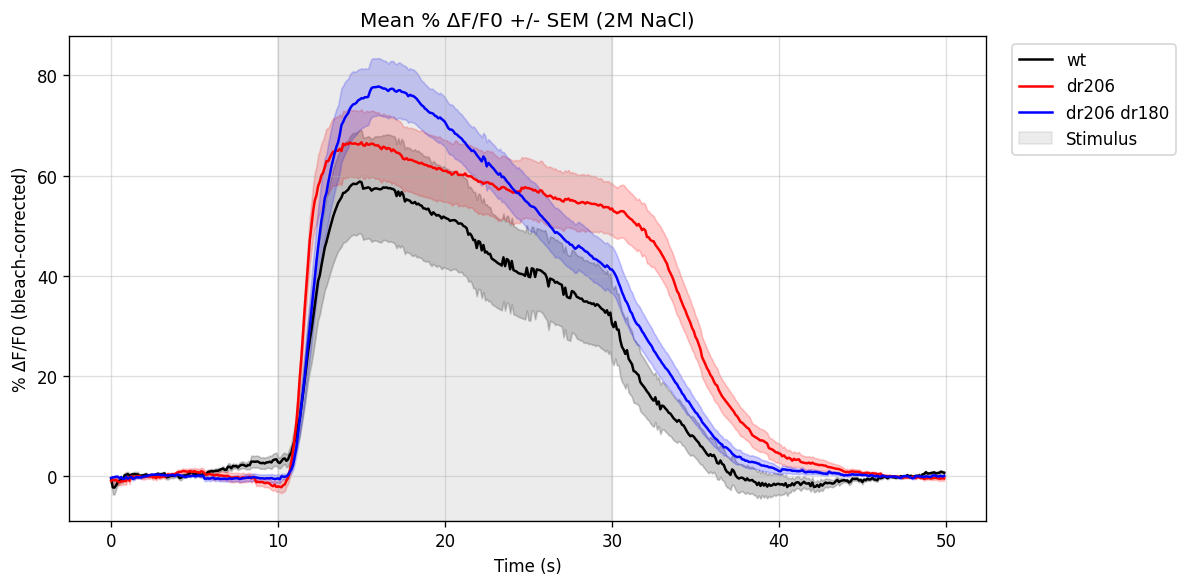

In [9]:
# Plot mean +/- SEM for each genotype (bleach-corrected data)
# Omit first 10 seconds and plot 10-60s period with renumbered time axis
plot_start = 10  # seconds
plot_end = 60    # seconds

group_stats = {}
for name, df in group_data_bleach_corrected.items():
    # Filter to plot window
    plot_mask = (df[time_col] >= plot_start) & (df[time_col] <= plot_end)
    df_plot = df[plot_mask].copy()
    
    # Renumber time axis starting from 0
    df_plot[time_col] = df_plot[time_col] - plot_start
    
    data_cols = [c for c in df_plot.columns if c != time_col]
    group_stats[name] = {
        "time": df_plot[time_col], 
        "mean": df_plot[data_cols].mean(axis=1), 
        "sem": df_plot[data_cols].sem(axis=1)
    }

fig, ax = plt.subplots(figsize=(10, 5))
for name, stats in group_stats.items():
    color = palette.get(name)
    ax.plot(stats["time"], stats["mean"], label=name, color=color)
    ax.fill_between(stats["time"], stats["mean"] - stats["sem"], stats["mean"] + stats["sem"], alpha=0.2, color=color)

ax.set_xlabel("Time (s)")
ax.set_ylabel("% ΔF/F0 (bleach-corrected)")
stim_label = f"{stimulus_info.get('concentration', '')} {stimulus_info.get('type', 'stimulus')}"
ax.set_title(f"Mean % ΔF/F0 +/- SEM ({stim_label})")
ax.grid(True, alpha=0.4)

# Adjust stimulus window for renumbered time axis
adjusted_stim_start = max(0, stim_window[0] - plot_start)
adjusted_stim_end = stim_window[1] - plot_start
ax.axvspan(adjusted_stim_start, adjusted_stim_end, color="gray", alpha=0.15, label="Stimulus")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

out_path = FIGURES_DIR / "mean_deltaF_F0_over_time.png"
fig.tight_layout()
fig.savefig(out_path, dpi=300)
print(f"Saved {out_path}")
print(f"Plotted time window: {plot_start}-{plot_end}s (renumbered to 0-{plot_end-plot_start}s)")

plt.show()

In [ ]:
# Export bleach-corrected data for each genotype
for genotype, df in group_data_bleach_corrected.items():
    genotype_tag = sanitize_name(genotype)
    out_file = FIGURE_DATA_DIR / f"{genotype_tag}_bleach_corrected.csv"
    df.to_csv(out_file, index=False)
    print(f"Saved bleach-corrected data for '{genotype}' to {out_file.name}")

Saved heatmap for 'wt' to wt_heatmap.png (15 traces, scale: -10 to 60%)


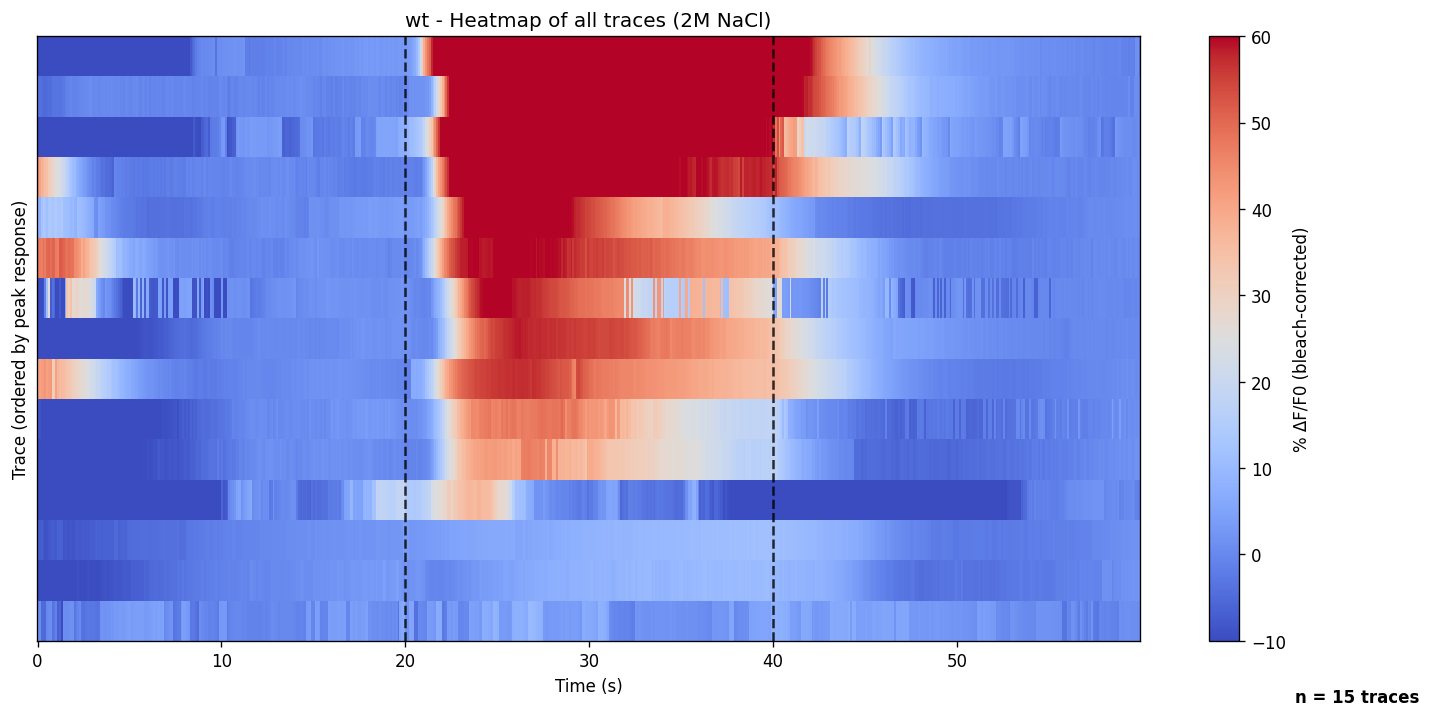

Saved heatmap for 'dr206' to dr206_heatmap.png (15 traces, scale: -10 to 60%)


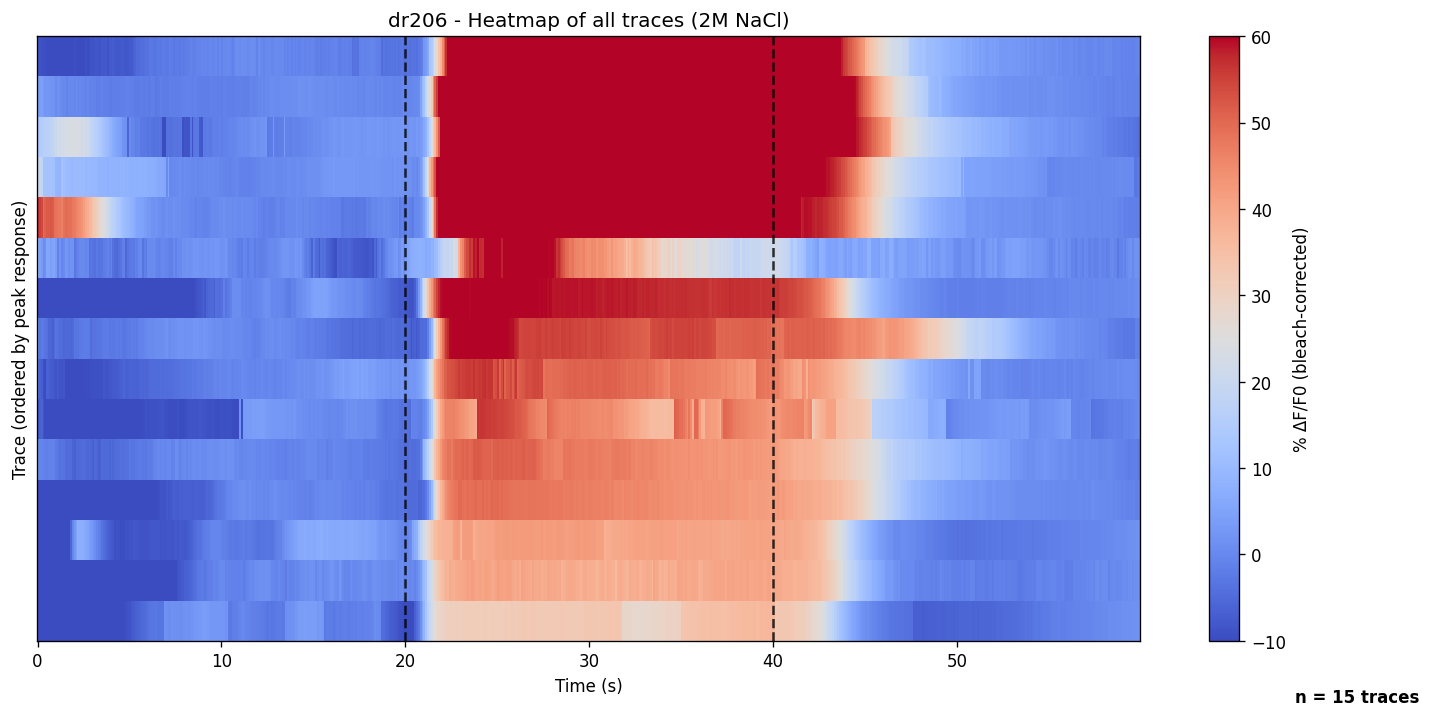

Saved heatmap for 'dr206 dr180' to dr206_dr180_heatmap.png (16 traces, scale: -10 to 60%)


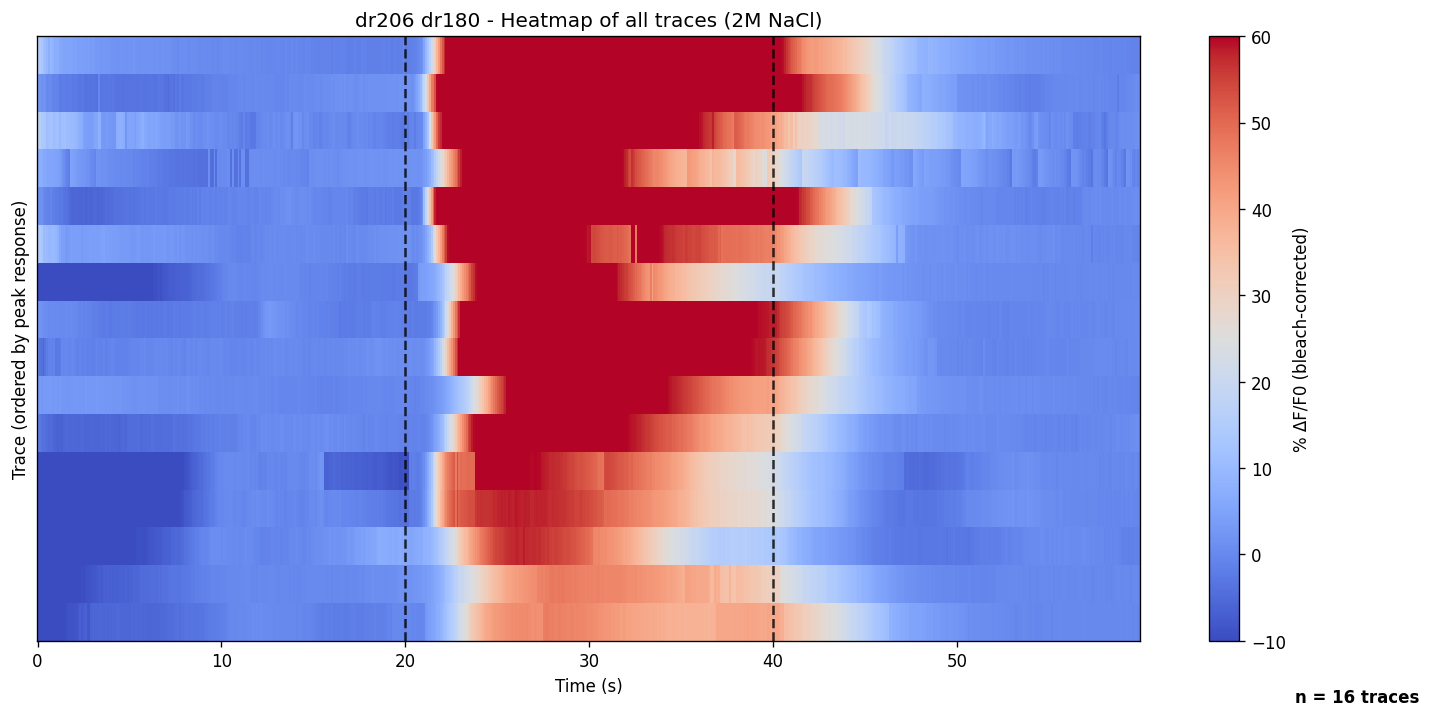

In [ ]:
# Generate heatmaps for each genotype, ordered by peak response
import matplotlib.colors as mcolors

for genotype, df in group_data_bleach_corrected.items():
    data_cols = [c for c in df.columns if c != time_col]
    
    # Find peak response for each trace during stimulus window
    stim_mask = (df[time_col] >= stim_window[0]) & (df[time_col] <= stim_window[1])
    stim_data = df[stim_mask]
    peak_responses = stim_data[data_cols].max()
    
    # Sort traces by peak response (highest to lowest)
    sorted_traces = peak_responses.sort_values(ascending=False).index.tolist()
    
    # Create heatmap data matrix (traces x time)
    heatmap_data = df[sorted_traces].T.values
    
    # Create figure (height reduced by 50%)
    fig, ax = plt.subplots(figsize=(12, max(3, len(sorted_traces) * 0.075)))
    
    # Fixed scale: -10 to +60%
    vmin = -10
    vmax = 60
    
    # Use coolwarm colormap: Blue (cold/low) to Red (hot/high)
    im = ax.imshow(heatmap_data, aspect='auto', cmap='coolwarm', 
                   vmin=vmin, vmax=vmax, interpolation='nearest')
    
    # Set x-axis (time) - show every 10 seconds
    time_values = df[time_col].values
    # Find indices where time is a multiple of 10 seconds
    tick_times = np.arange(0, time_values[-1] + 10, 10)  # 0, 10, 20, 30, ...
    tick_indices = [np.argmin(np.abs(time_values - t)) for t in tick_times if t <= time_values[-1]]
    tick_labels = [int(time_values[i]) for i in tick_indices]
    
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Time (s)")
    
    # Set y-axis (traces)
    ax.set_ylabel("Trace (ordered by peak response)")
    ax.set_yticks([])  # Hide individual trace labels
    
    # Add stimulus window shading
    stim_start_idx = np.argmin(np.abs(time_values - stim_window[0]))
    stim_end_idx = np.argmin(np.abs(time_values - stim_window[1]))
    ax.axvline(stim_start_idx, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(stim_end_idx, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label="% ΔF/F0 (bleach-corrected)")
    
    # Add title and trace count label
    stim_label = f"{stimulus_info.get('concentration', '')} {stimulus_info.get('type', 'stimulus')}"
    ax.set_title(f"{genotype} - Heatmap of all traces ({stim_label})")
    
    # Add trace count label at bottom right
    n_traces = len(sorted_traces)
    fig.text(0.99, 0.01, f"n = {n_traces} traces", 
             ha='right', va='bottom', fontsize=10, fontweight='bold')
    
    fig.tight_layout()
    
    # Save figure
    genotype_tag = sanitize_name(genotype)
    heatmap_path = FIGURES_DIR / f"{genotype_tag}_heatmap.png"
    fig.savefig(heatmap_path, dpi=300, bbox_inches='tight')
    print(f"Saved heatmap for '{genotype}' to {heatmap_path.name} ({n_traces} traces, scale: {vmin} to {vmax}%)")
    
    plt.show()



Pairwise t-test p-values:
  wt vs dr206: p = 0.5514 ns
  wt vs dr206 dr180: p = 0.0988 ns
  dr206 vs dr206 dr180: p = 0.1759 ns

Saved data\processed\260123\figures\peak_deltaF_F0_bar.png
Saved data\processed\260123\figure_data\peak_deltaF_F0_values.csv
Saved data\processed\260123\figure_statistics\peak_deltaF_F0_statistics.csv
Saved data\processed\260123\figure_statistics\peak_deltaF_F0_pvalues.csv


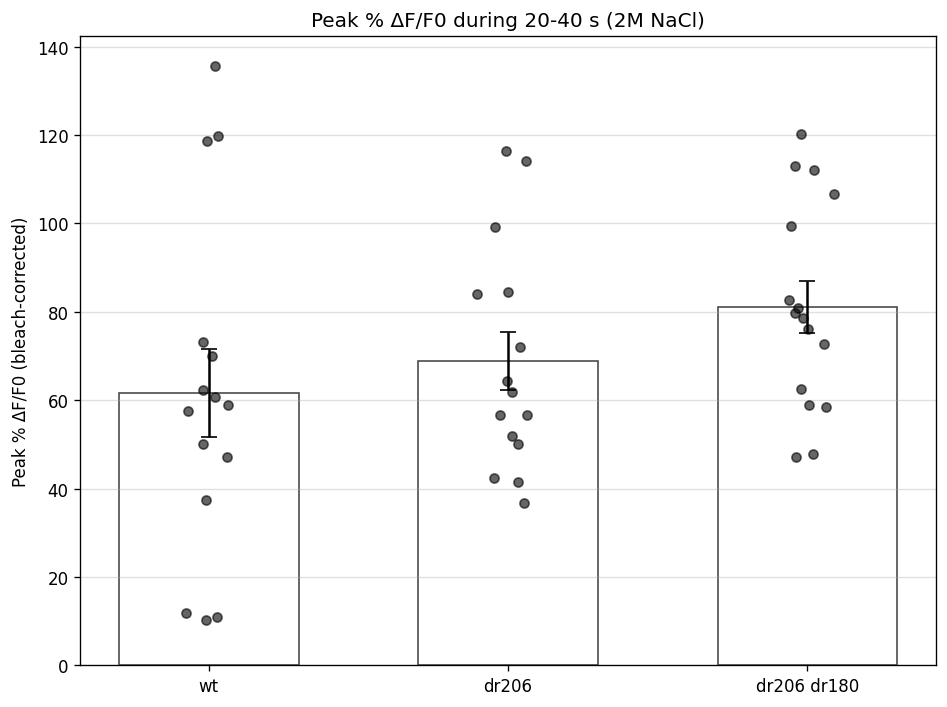

In [11]:
# Extract stimulus-period peaks and plot bar chart with individual points
from scipy import stats

peak_frames = []
for name, df in group_data_bleach_corrected.items():
    window = df[(df[time_col] >= stim_window[0]) & (df[time_col] <= stim_window[1])]
    data_cols = [c for c in df.columns if c != time_col]
    peaks = window[data_cols].max()
    peaks.name = name
    peak_frames.append(peaks)

peak_df = pd.concat(peak_frames, axis=1)
mean_peak = peak_df.mean()
sem_peak = peak_df.sem()

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
x_positions = range(len(mean_peak))
bars = ax.bar(x_positions, mean_peak.values, yerr=sem_peak.values, capsize=5, 
               color="white", edgecolor="black", width=0.6, alpha=0.7)

# Plot individual data points
np.random.seed(42)  # for reproducible jitter
for i, genotype in enumerate(mean_peak.index):
    values = peak_df[genotype].values
    # Add jitter to x position for visibility
    x_jitter = np.random.normal(i, 0.04, size=len(values))
    ax.scatter(x_jitter, values, color='black', alpha=0.6, s=30, zorder=3)

ax.set_xticks(x_positions)
ax.set_xticklabels(mean_peak.index)
ax.set_ylabel("Peak % ΔF/F0 (bleach-corrected)")
stim_label = f"{stimulus_info.get('concentration', '')} {stimulus_info.get('type', 'stimulus')}"
ax.set_title(f"Peak % ΔF/F0 during {stim_window[0]}-{stim_window[1]} s ({stim_label})")
ax.grid(axis="y", alpha=0.4)

# Calculate p-values between all pairs of genotypes
genotype_list = list(mean_peak.index)
print("\nPairwise t-test p-values:")
pvalue_results = []
for i in range(len(genotype_list)):
    for j in range(i + 1, len(genotype_list)):
        g1, g2 = genotype_list[i], genotype_list[j]
        values1 = peak_df[g1].dropna().values
        values2 = peak_df[g2].dropna().values
        
        if len(values1) > 1 and len(values2) > 1:
            t_stat, p_val = stats.ttest_ind(values1, values2)
            pvalue_results.append({
                "comparison": f"{g1} vs {g2}",
                "t_statistic": t_stat,
                "p_value": p_val,
                "significant": "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            })
            print(f"  {g1} vs {g2}: p = {p_val:.4f} {pvalue_results[-1]['significant']}")

fig.tight_layout()

bar_path = FIGURES_DIR / "peak_deltaF_F0_bar.png"
fig.savefig(bar_path, dpi=300)
print(f"\nSaved {bar_path}")

peaks_path = FIGURE_DATA_DIR / "peak_deltaF_F0_values.csv"
peak_df.T.to_csv(peaks_path)
print(f"Saved {peaks_path}")

# Save statistics (mean, SEM, and p-values)
stats_df = pd.DataFrame({
    "genotype": mean_peak.index, 
    "mean_peak": mean_peak.values, 
    "sem_peak": sem_peak.values,
    "n": [peak_df[g].count() for g in mean_peak.index]
})
stats_path = FIGURE_STATS_DIR / "peak_deltaF_F0_statistics.csv"
stats_df.to_csv(stats_path, index=False)
print(f"Saved {stats_path}")

# Save p-values
if pvalue_results:
    pvalue_df = pd.DataFrame(pvalue_results)
    pvalue_path = FIGURE_STATS_DIR / "peak_deltaF_F0_pvalues.csv"
    pvalue_df.to_csv(pvalue_path, index=False)
    print(f"Saved {pvalue_path}")

plt.show()

In [13]:
# List generated outputs
print("\nFigures:")
for path in sorted(FIGURES_DIR.glob("*")):
    if path.is_file():
        size_kb = path.stat().st_size / 1024
        print(f"  {path.name} ({size_kb:.1f} KB)")
        
print("\nFigure Data:")
for path in sorted(FIGURE_DATA_DIR.glob("*")):
    if path.is_file():
        size_kb = path.stat().st_size / 1024
        print(f"  {path.name} ({size_kb:.1f} KB)")
        
print("\nFigure Statistics:")
for path in sorted(FIGURE_STATS_DIR.glob("*")):
    if path.is_file():
        size_kb = path.stat().st_size / 1024
        print(f"  {path.name} ({size_kb:.1f} KB)")


Figures:
  mean_deltaF_F0_over_time.png (408.0 KB)
  peak_deltaF_F0_bar.png (124.9 KB)

Figure Data:
  dr206_bleach_corrected.csv (169.4 KB)
  dr206_dr180_bleach_corrected.csv (182.2 KB)
  peak_deltaF_F0_values.csv (4.0 KB)
  wt_bleach_corrected.csv (170.6 KB)

Figure Statistics:
  peak_deltaF_F0_pvalues.csv (0.2 KB)
  peak_deltaF_F0_statistics.csv (0.2 KB)
